In [82]:
import librosa
import numpy as np
import pandas as pd
import math
import os
import IPython.display as ipd
import pandas as pd

## Dataset folders
data_root = "/homes/alb30/datasets/"
smt_guitar_root = data_root + "IDMT-SMT-GUITAR/"
guitarset_root = data_root + "GuitarSet/"
gpt_root = data_root + "GuitarPlayingTechniques/"

In [83]:
from src.data_preparation import SMTGuitar 
smt_guitar = SMTGuitar(data_root)

In [84]:
data_loaded = smt_guitar.load_data(path='data/')

Data loaded successfully
True
                 name  lick   mono guitar excitation expression  position  \
0        AR_Lick10_FN    10  False     AR         FS         NO         0   
1        AR_Lick10_KN    10  False     AR         MU         NO         0   
2        AR_Lick10_MN    10  False     AR         PK         NO         0   
3        AR_Lick11_FN    11   True     AR         FS         NO         0   
4        AR_Lick11_KN    11   True     AR         MU         NO         0   
..                ...   ...    ...    ...        ...        ...       ...   
193  LP_Lick9_FN_Lage     9  False     LP         FS         NO         1   
194       LP_Lick9_KN     9  False     LP         MU         NO         0   
195  LP_Lick9_KN_Lage     9  False     LP         MU         NO         1   
196       LP_Lick9_MN     9  False     LP         PK         NO         0   
197  LP_Lick9_MN_Lage     9  False     LP         PK         NO         1   

        fs      len            ms  \
0    441

In [85]:
if not data_loaded[0]:
    smt_guitar.extract_audio()
    smt_guitar.extract_annotations()
    smt_guitar.extract_transcript()

In [86]:
if not data_loaded[0]:
    smt_guitar.get_simple_transcript()
    smt_guitar.save_data(path='data/')

Number of mono clips: 135


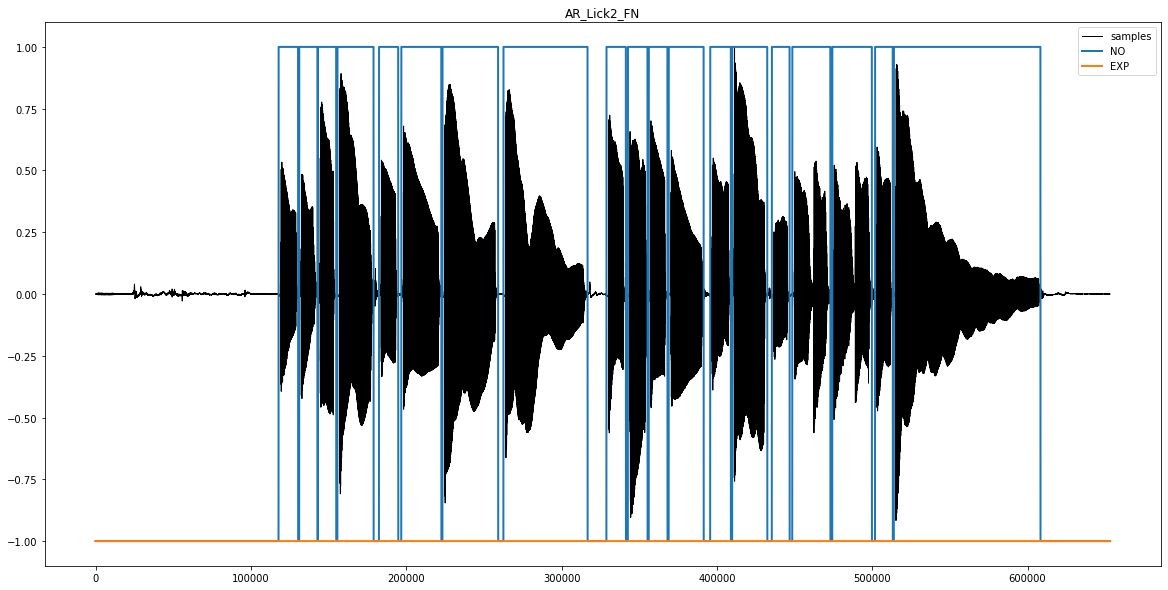

In [87]:
from random import randint
mono_clips = smt_guitar.filter_by({'mono': True})
print("Number of mono clips:", len(mono_clips))
link = mono_clips.sample(n=1) 
idx = link.index[0]
smt_guitar.plot_annotations(idx=idx, simple=True)
ipd.Audio(**smt_guitar.play_data(idx=idx))

In [88]:
bend = smt_guitar.filter_by({'expression': 'BE'})
slide = smt_guitar.filter_by({'expression': 'SL'})
bend_and_slide = pd.concat([bend, slide], axis=1, join='inner')

mono_licks = smt_guitar.filter_by({'mono': True})

import random
el = random.randint(0,len(mono_licks.index))
lick = smt_guitar.get_by_order(el=el, df=mono_licks)
ipd.Audio(**smt_guitar.play_data(idx=lick.name))

In [89]:
idx = 4
array = np.where(smt_guitar.df['transcript'][idx]==1)[0]

# array.unique()
unique_array = np.unique(array)
exp_array = np.array(list(smt_guitar.styles['expression']))
print(exp_array[unique_array], smt_guitar.df['num_exp'][idx])
exp_in_trans = list({key:value for (key,value) in smt_guitar.df['num_exp'][idx].items() if value != 0}.keys())
print(exp_in_trans)

print(set(exp_array[unique_array])==set(exp_in_trans))


['NO' 'BE' 'HA' 'SL' 'VI'] {'NO': 44, 'BE': 13, 'DN': 0, 'HA': 3, 'SL': 2, 'VI': 5}
['NO', 'BE', 'HA', 'SL', 'VI']
True


In [90]:
mono_clips = smt_guitar.filter_by({'mono': True})
print(len(mono_clips))

135


In [137]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
from src.feature_extraction import compute_mel_spectrograms 
import src.utils as utils 
mono_df = smt_guitar.filter_by({'mono': True})
mono_mel_spec_pkl = 'mono_mel_spec.pkl'

# Extract mel spectrograms
mel_loaded, mel_spectrograms = utils.load_dataframe(mono_mel_spec_pkl, path='data/')
# mel_loaded = False
if not mel_loaded:
    print('Compute Mel spectrograms')
    mel_spectrograms = compute_mel_spectrograms(mono_df)
    mel_spectrograms.to_pickle('data/'+mono_mel_spec_pkl)


Data loaded successfully
Compute Mel spectrograms


In [139]:
from src.data_preparation import get_clip_labels 

label_dataframe = get_clip_labels(mono_df, exp=smt_guitar.styles['expression'])

In [181]:
# Get stack of one-hot labels and label weights
from src.data_preparation import get_one_hot_labels

one_hot_labels, label_weights = get_one_hot_labels(label_dataframe)


print(label_weights)
label_encoding = []
for row in one_hot_labels:
    label_encoding.append(pd.DataFrame(row))

[0.16666667 0.5        0.83333333 0.625      0.5        0.5       ]


In [141]:
from src.feature_extraction import zero_pad_spectrograms 

# Pad spectrograms to retain dimensiononality
spectrograms = zero_pad_spectrograms(mel_spectrograms)

In [179]:
from sklearn.model_selection import train_test_split

## Create train and test sets
train_sets = list()
test_sets = list()

# Split for one the first set of spectrograms
X_train, X_test, y_train, y_test = train_test_split(spectrograms[0], np.array(one_hot_labels))

train_sets.append(X_train)
test_sets.append(X_test)

train_indices = X_train.index
test_indices = X_test.index

for idx, spec in enumerate(spectrograms[1:]):
        train_sets.append(pd.DataFrame(spec, index=train_indices))
        test_sets.append(pd.DataFrame(spec, index=test_indices))

# Sanity check
print('Training examples:', len(X_train))
print('.....Num features', X_train.values[0][0].shape[1])
print('.....Num frames', X_train.values[0][0].shape[0])

print('Test examples:', len(X_test))
print('.....Num features', X_test.values[0][0].shape[1])
print('.....Num frames', X_test.values[0][0].shape[0])

Training examples: 101
.....Num features 128
.....Num frames 782
Test examples: 34
.....Num features 128
.....Num frames 782


In [182]:
from src.feature_extraction import standardize_spectrogram 
from src.feature_extraction import prepare_input_dimensions

X_train_std, scaler = standardize_spectrogram(X_train)
X_test_std, _ = standardize_spectrogram(X_test, scaler)

X_train_std_format = prepare_input_dimensions(X_train_std)
X_test_std_format = prepare_input_dimensions(X_test_std)

std_train_sets = []
format_train_sets = []

std_test_sets = []
format_test_sets = []

std_train_sets.append(X_train_std)
format_train_sets.append(X_train_std_format)

std_test_sets.append(X_test_std)
format_test_sets.append(X_test_std_format)



for idx, spec in enumerate(spectrograms[1:]):
    _train_std, _scaler = standardize_spectrogram(train_sets[idx])
    _test_std, _ = standardize_spectrogram(test_sets[idx], _scaler)

    std_train_sets.append(_train_std)
    format_train_sets.append( prepare_input_dimensions(_train_std) )
    
    std_test_sets.append(_test_std)
    format_test_sets.append( prepare_input_dimensions(_test_std) )

In [23]:
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Input

Using TensorFlow backend.


In [185]:
n_features = format_train_sets[0].shape[1]
n_frames = format_train_sets[0].shape[2]

input_shape = (n_features, n_frames, 1)

print('Input shape', input_shape)

inputs = []
for i, ts in enumerate(train_sets):
    name = 'input_'+str(i)
    inputs.append(Input(input_shape, name=name))

Input shape (128, 782, 1)


In [26]:
from src.models import *

In [27]:
ws=[512, 1024, 2048, 4096, 8192, 16384]

early_convolutions = []
ec_outputs = []
for idx, inpt in enumerate(inputs):
    early_convolutions.append(EarlyConvolution(inpt, name=str(ws[idx])+'_'))
    early_convolutions[idx].define_layers()
    ec_outputs.append(early_convolutions[idx].output_layer)

In [28]:
late_convolution = LateConvolution(input_layers=ec_outputs)
lc_output = late_convolution.define_layers()

In [30]:
recurrent = Recurrent(input_layer=lc_output, seq_len=n_frames)
re_output = recurrent.define_layers()

In [31]:
classifier = Classifier(input_layer=recurrent.output_layer)
cl_output = classifier.define_layers()

In [ ]:
model = Model(inputs=inputs, outputs=classifier.output_layer)
model.compile(loss='categorical_crossentropy',optimizer='adam')
model.summary() 

In [33]:
def load_theano_model(fp):
    with np.load(fp) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    return param_values

clip2frame_model_path = 'models/model.20160309_111546.npz'
c2f_model = load_theano_model(clip2frame_model_path)

In [34]:
npzfile = np.load('models/model.20160309_111546.npz')

In [35]:
for f in npzfile.files:
    print(f, npzfile[f].shape)
    


arr_24 (512, 192, 1, 1)
arr_25 (512,)
arr_26 (512, 512, 1, 1)
arr_27 (512,)
arr_20 (32, 1, 8, 128)
arr_21 (32,)
arr_22 (32, 32, 8, 1)
arr_23 (32,)
arr_28 (188, 512, 1, 1)
arr_29 (188,)
arr_30 (188,)
arr_19 (32,)
arr_18 (32, 32, 8, 1)
arr_11 (32,)
arr_10 (32, 32, 8, 1)
arr_13 (32,)
arr_12 (32, 1, 8, 128)
arr_15 (32,)
arr_14 (32, 32, 8, 1)
arr_17 (32,)
arr_16 (32, 1, 8, 128)
arr_1 (32,)
arr_0 (32, 1, 8, 128)
arr_3 (32,)
arr_2 (32, 32, 8, 1)
arr_5 (32,)
arr_4 (32, 1, 8, 128)
arr_7 (32,)
arr_6 (32, 32, 8, 1)
arr_9 (32,)
arr_8 (32, 1, 8, 128)


In [36]:
# print(c2f_model)
print(type(c2f_model))
for l, p in enumerate(c2f_model):
    print(l, len(p))


<class 'list'>
0 32
1 32
2 32
3 32
4 32
5 32
6 32
7 32
8 32
9 32
10 32
11 32
12 32
13 32
14 32
15 32
16 32
17 32
18 32
19 32
20 32
21 32
22 32
23 32
24 512
25 512
26 512
27 512
28 188
29 188
30 188


In [37]:
import random
el = random.randint(0,len(mono_licks.index))
lick = smt_guitar.get_by_order(el=el, df=mono_licks)

In [38]:
samples = lick['samples']
fs = lick['fs']
re_samples = librosa.resample(samples, fs, 16000)

mbe = extract_mbe(_y=re_samples, _sr=16000, _nfft=512, _nb_mel=128)

NameError: name 'extract_mbe' is not defined

In [ ]:
print(mbe.shape)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(mbe)
data_in=X_train
shape=(data_in.shape[-2], data_in.shape[-1])
